Code from https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655/code

In [ ]:
# submit History
# 0.0652418 : initial submit
# 0.0649065 : some change?
# 0.0979253 : fillna with mean value, convert_outlier
# 0.0984987 : remove convert_outlier
# 0.0654573 : remove fillna with mean value
# ? : TODO apply convert_outlier to logerror


In [64]:
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [65]:
def draw_scatter_plot(df, col_name):
    np_array = df[col_name].values
    
    plt.figure(figsize=(8,6))
    plt.scatter(range(len(np_array)), np.sort(np_array))
    plt.xlabel('index', fontsize=12)
    plt.ylabel(col_name, fontsize=12)
    plt.show()
    
    
def draw_dist_plot(df, col_name):
    np_array = df[col_name].values
    
    plt.figure(figsize=(12,8))
    sns.distplot(np_array, bins=50, kde=False)
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.show()
    
    
def draw_count_plot(df, col_name, title='plot'):
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=col_name)
    plt.xticks(rotation='vertical')
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.title(title, fontsize=15)
    plt.show()
    
    
def draw_box_plot(df, x_col, y_col):
    plt.figure(figsize=(12,8))
    sns.boxplot(data=df, x=x_col, y=y_col)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.show()
    
    
def draw_violin_plot(df, x_col, y_col):
    plt.figure(figsize=(12,8))
    sns.violinplot(data=df, x=x_col, y=y_col)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.show()
    

def draw_plots(df, col_name):
    draw_scatter_plot(df, col_name)
    draw_dist_plot(df, col_name)

    
def draw_np_array_scatter_plot(np_array, col_name):
    plt.figure(figsize=(8,6))
    plt.scatter(range(len(np_array)), np.sort(np_array))
    plt.xlabel('index', fontsize=12)
    plt.ylabel(col_name, fontsize=12)
    plt.show()
    
    
def draw_np_array_dist_plot(np_array, col_name):
    plt.figure(figsize=(12,8))
    sns.distplot(np_array, bins=50, kde=False)
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('count', fontsize=12)
    plt.show()
    

def convert_outlier_value(df, col_name, upper_percentile=99.0, lower_percentile=1.0):
    np_array = df[col_name].values
    
    ulimit = np.percentile(np_array, upper_percentile)
    llimit = np.percentile(np_array, lower_percentile)
    print('upper limit :', ulimit, ', lower limit :', llimit)
    
    # convert
    df[col_name].loc[df[col_name] > ulimit] = ulimit
    df[col_name].loc[df[col_name] < llimit] = llimit


In [66]:
print('Loading data ...')

train_df = pd.read_csv('input/train_2016_v2.csv', parse_dates=['transactiondate'])
prop_df = pd.read_csv('input/properties_2016.csv')
sample = pd.read_csv('input/sample_submission.csv')

Loading data ...


/home/voyageth/develop/anaconda3/envs/kaggle/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [67]:
print('Binding to float32')

for c, dtype in zip(prop_df.columns, prop_df.dtypes):
    if dtype == np.float64:
        prop_df[c] = prop_df[c].astype(np.float32)

Binding to float32


In [68]:
print('df_train.shape :', train_df.shape)
display(train_df.head())

df_train.shape : (90275, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


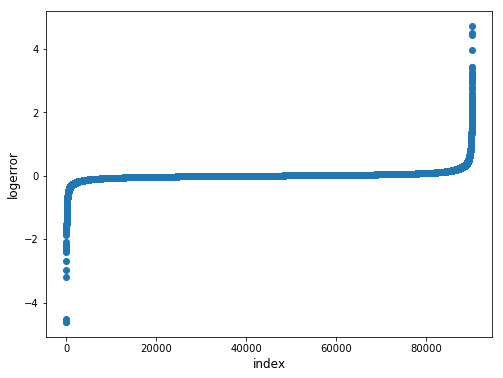

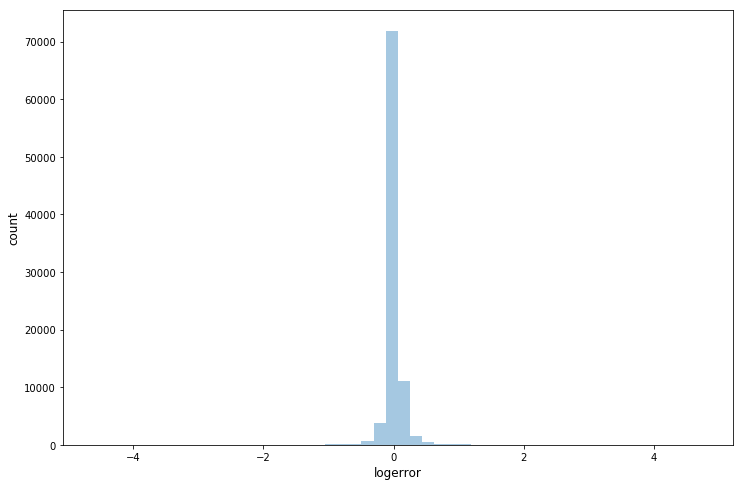

In [69]:
draw_plots(train_df, 'logerror')

In [70]:
# convert_outlier_value(train_df, 'logerror', lower_percentile=1, upper_percentile=99)

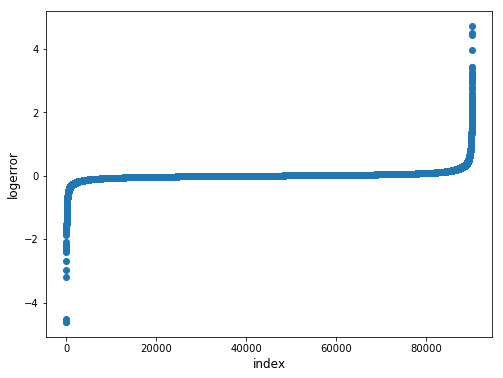

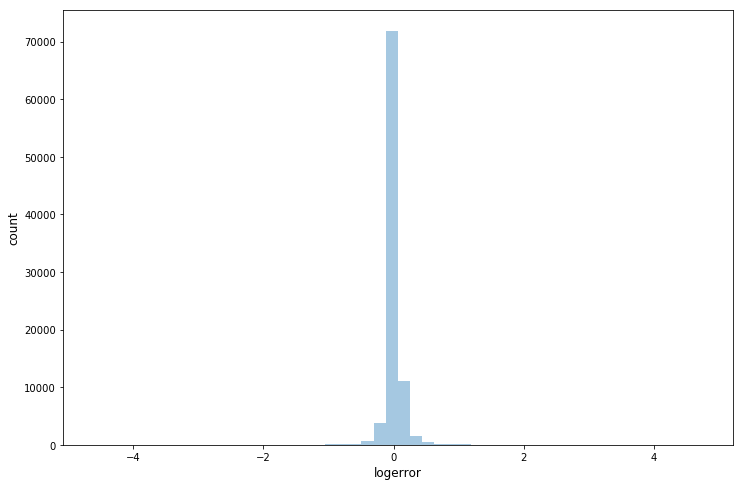

In [71]:
draw_plots(train_df, 'logerror')

In [72]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='missing_count', ascending=False)
missing_df['missing_ratio'] = missing_df['missing_count'] / len(prop_df)
display(missing_df)

,column_name,missing_count,missing_ratio
41,storytypeid,2983593,0.999456
3,basementsqft,2983589,0.999455
46,yardbuildingsqft26,2982570,0.999113
49,fireplaceflag,2980054,0.998270
2,architecturalstyletypeid,2979156,0.997970
43,typeconstructiontypeid,2978470,0.997740
13,finishedsquarefeet13,2977545,0.997430
6,buildingclasstypeid,2972588,0.995769
9,decktypeid,2968121,0.994273
16,finishedsquarefeet6,2963216,0.992630


In [73]:
print('Creating training set ...')

df_train = train_df.merge(prop_df, how='left', on='parcelid')
df_train.head()

Creating training set ...


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,60371068.0,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,60590524.0,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,60374640.0,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,60372964.0,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,60590424.0,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13


In [74]:
pd.options.display.max_rows = 65
dtype_df = df_train.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,1
2,datetime64[ns],1
3,float32,52
4,object,5


In [75]:
# fillna with mean value
mean_values = df_train.mean(axis=0)
# df_train = df_train.fillna(mean_values) # not good choice? LB increased to 0.09!

In [76]:
missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / df_train.shape[0]
missing_df.loc[missing_df['missing_ratio'] > 0]['column_name']

3            airconditioningtypeid
4         architecturalstyletypeid
5                     basementsqft
8              buildingclasstypeid
9            buildingqualitytypeid
10               calculatedbathnbr
11                      decktypeid
12        finishedfloor1squarefeet
13    calculatedfinishedsquarefeet
14            finishedsquarefeet12
15            finishedsquarefeet13
16            finishedsquarefeet15
17            finishedsquarefeet50
18             finishedsquarefeet6
20                    fireplacecnt
21                     fullbathcnt
22                    garagecarcnt
23                 garagetotalsqft
24                  hashottuborspa
25           heatingorsystemtypeid
28               lotsizesquarefeet
29                         poolcnt
30                     poolsizesum
31                    pooltypeid10
32                     pooltypeid2
33                     pooltypeid7
34       propertycountylandusecode
36              propertyzoningdesc
38                  

In [77]:
print(df_train['taxdelinquencyflag'].value_counts())
df_train['taxdelinquencyflag'] = df_train['taxdelinquencyflag'] \
                .apply(lambda x: True if x == True or x == 'Y' else False)
print(df_train['taxdelinquencyflag'].value_counts())

Y    1783
Name: taxdelinquencyflag, dtype: int64
False    88492
True      1783
Name: taxdelinquencyflag, dtype: int64


In [78]:
# df_train = df_train.fillna('UNKNOWN')

In [79]:
convert_outlier_value(df_train, 'finishedsquarefeet12', lower_percentile=0.5, upper_percentile=99.5)

upper limit : nan , lower limit : nan


/home/voyageth/develop/anaconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [80]:
convert_outlier_value(df_train, 'calculatedfinishedsquarefeet', lower_percentile=0.5, upper_percentile=99.5)

upper limit : nan , lower limit : nan


/home/voyageth/develop/anaconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [81]:
convert_outlier_value(df_train, 'taxamount', lower_percentile=0.5, upper_percentile=99.5)

upper limit : nan , lower limit : nan


/home/voyageth/develop/anaconda3/envs/kaggle/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [82]:
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 
                         'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

(90275, 55) (90275,)
Building DMatrix...


In [83]:
print('Training ...')

xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'silent': 1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(xgb_params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

Training ...
[0]	train-mae:0.479881	valid-mae:0.472958
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.335647	valid-mae:0.328957
[20]	train-mae:0.238757	valid-mae:0.232561
[30]	train-mae:0.174448	valid-mae:0.168915
[40]	train-mae:0.132411	valid-mae:0.127551
[50]	train-mae:0.105671	valid-mae:0.101447
[60]	train-mae:0.089278	valid-mae:0.085609
[70]	train-mae:0.079654	valid-mae:0.076619
[80]	train-mae:0.07424	valid-mae:0.071776
[90]	train-mae:0.071273	valid-mae:0.069254
[100]	train-mae:0.069625	valid-mae:0.067984
[110]	train-mae:0.068702	valid-mae:0.067345
[120]	train-mae:0.06815	valid-mae:0.067025
[130]	train-mae:0.067833	valid-mae:0.066897
[140]	train-mae:0.067624	valid-mae:0.066832
[150]	train-mae:0.067475	valid-mae:0.066803
[160]	train-mae:0.067374	valid-mae:0.066801
[170]	train-mae:0.06729	valid-mae:0.066816
[180]	train-mae:0.067218	valid-mae:0.066836
[190]	train-mae:0.067

In [84]:
print('Building test set ...')

sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop_df, on='parcelid', how='left')

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

d_test = xgb.DMatrix(x_test)
print('Predicting on test ...')

p_test = clf.predict(d_test)

sub = pd.read_csv('input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('output/xgb_starter.csv', index=False, float_format='%.4f') # Thanks to @inversion
print('Write finished')

Building test set ...
Predicting on test ...
Writing csv ...
Write finished
